<a href="https://colab.research.google.com/github/Unit404/CapsherDiscordBot/blob/main/Final_Deliverable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seasonal Seasoning
### Identifying the key ingredients in holiday recipes

# Introduction

##Primary goals

The primary goals of this project is to identify staple ingredients during holidays, and to identify relations between holidays via ingredients

### How the goals shifted during the project
Initially, the plan was to classify recipes into to seasons based on their ingredients. however, we ended up steering away from this because the small dataset we ended up with made it hard to do, and we found investigating staple ingreadietnts and relations between holidays to be more interesting.

As such our plan changed to text clustering and data observation to identify these staple ingredients and relationships. We wanted to also potentially explore the trends in the tags, categories, and descritpions of each recipe; but we determined that this would make the scope of the project too big.



##Motivation 
A lot of people love different times of the year because of the foods they eat during that season.
For example, some people long for Fall because of Pumpkin Spice Lattes and warm soups
whereas others wait for Summer so they can barbecue and cool down with frozen drinks.

Additionally, a lot of seasons are associated with various themes. This means that seasonal food also tend to reflect these themes. an investigation into what ingredients are used to help reflect themes can help people make their own holiday/season themed dish.


In [ ]:
#imports
import requests
import re
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

## Data Collection
To collect data from Allrecipes.com, we use regex and beautiful soup.
Allrecipes.com has a web page for all 9 holidays that contains several recipes.
Each recipe's webpage is consistently layed out the same way, this makes it easy to parse the webpage for information. 

The process to scrape data from this website is first we go to the webpage which contains links to all of the holiday webpages (https://www.allrecipes.com/recipes/85/holidays-and-events/)

Then from there, we get an array of links to the holiday webpages.

Then for each holiday webpage, we get an array of links to recipes for those holidays.

Then we scrape each recipe's webpage for data.








Given a url and a list of seasons, **getSeasonsLinks()** searches through the url's html tags which have links to seasonal recipes. If one of the holidays in the seasons list is included in the url, the link is returned.

In [ ]:
#Sarika
def getSeasonLinks(url, seasons): 
  req = requests.get(url)
  soup = BeautifulSoup(req.content, 'html.parser')
  all_links = []
  for link in soup.findAll('a', {'class': "submenu-link child-link"}):
    try:
        all_links.append(link['href'])
    except KeyError:
        pass
  season_links = []
  for link in all_links:
    for season in seasons:
      if season in link:
        season_links.append(link)
  return season_links

Given a url, **getLinks()** gets the exact link of each recipe's page and forwards it to the last functon that parses the ingredients from the page source.

In [ ]:
def getLinks(url):
  text = []
  page = requests.get(url)
  soup = BeautifulSoup(page.content,'html.parser')
  for link in soup.findAll('a', {'class': "card__titleLink manual-link-behavior"}):
    try:
        text.append(link['href'])
    except KeyError:
        pass
  output = []
  for x in text:
    if x not in output:
        output.append(x)
  return output

Given an array and sep, **tostr()**  returns a string that is each element of the array, seperated by the given character

If the array is None, then return None.

Example: given ['red', 'orange', 'green'] and '|', it would return "red|orange|green|"

This is used to store arrays into a dataframe.

In [ ]:
#Jeremy
def tostr(arr, sep): #converts an array to a string where elements are seperated by an argument
  result = ""
  if arr==None:
    return None
  for part in arr:
    result+=part+sep
  return result


Given a url to a recipe from Allrecipes.com, **getInfo()** will return a tuple containing the title, description, ingredients, categories, calories, and tags of that recipe.

Any values not found will be replaced with None.



In [ ]:
#Jeremy
def getInfo(url): #given a url to a recipe, return it's title, description, ingredients, and type
  searchpage = requests.get(url)
  souppage = BeautifulSoup(searchpage.content, 'html.parser')
  textarea =souppage.find("script").get_text()
  textarea=textarea.replace("\n", "|")
  try:
  #get ingredients
    ingredients = re.search(r'\"recipeIngredient\"\: \[(.*?)\]', textarea)
    ingredients=ingredients.groups(1)[0].split(",|") 
    ingredients=[X.replace("|", "").strip().strip("\"").strip() for X in ingredients]
    for i, part in enumerate(ingredients):

      splt = part.split(" ")
      if(len(splt)<3):
        splt=tostr(splt[1:], " ")
      else:
        splt=tostr(splt[2:], " ")
      ingredients[i]=splt.strip()
  #got ingredients
  except:
    ingredients=None
  try:
  #get categories
    categories=re.search('\"recipeCategory\"\: \[(.*?)\]', textarea)
    categories=categories.groups(1)[0].split(",|")
    categories=[X.replace("|", "").strip().strip("\"").strip() for X in categories]
  #got categories
  except:
    ingredients=None
  try:
  #get title
    title=re.search('\"mainEntityOfPage\"\:.*?\"name\"\: \"([^\"]*?)\"', textarea)
    title=title.groups(1)[0]
  #got title
  except:
    title=None
  try:

  #get calories
    calories=re.search(r'\"calories\"\: \"(.*?) calories\"', textarea)
    calories=calories.groups(1)[0]
  #got calories
  except:
    calories=None
  #get description
  try:
    desc = re.search(r'\"description\"\: \"(.*?)\"', textarea)
    desc=desc.groups(1)[0]
  except:
    desc=None
  try:
    tagtext = souppage.find("script", {"id": "karma-loader"}).get_text()
    tagtext=tagtext.replace("\n", "|")
    tags = re.search(r'tags\: \[(.*?)\]', tagtext)
    tags=tags.groups(1)[0].split(",|") 
    tags=[X.replace("|", "").strip().strip("\"").strip() for X in tags]
    tags=tostr(tags, ", ")
  except:
    tags=None
  return title, desc, tostr(ingredients, ", "), tostr(categories, ", "), calories, tags

This cell invokes our three member functions to get the recipe information for each recipe on one of the holiday pages. We predefine the seasons list and the fields we want for the recipe. 

This process takes a few minutes, so we decided to save the dataframe to a csv file. The next cell loads in the csv file, so you are welcome to skip this cell.

##Data Storage
The structure of the data frame (and csv) is where each row is a recipe, and the columns are Title, Season, Description, Ingredients, Categories, Calories, and Tags.

We have about 40 recipes per season. This is a relatively small dataset for this project, but there were difficulties in collecting more data. In order to scrape data from Allrecipes.com, we had to write custom regex for each piece of data we collected. Doing this for many different sites, some of which may not have all of the data we wanted to collect, would be time consuming inefficient. Additionally, scraping additional recipes from Allrecipes.com proved to be difficult due to how the site is layed out.

In [ ]:
#Jeremy
seasons = ['new-year', 'valentines-day', 'mardi-gras', 'st-patricks-day', 'cinco-de-mayo', '4th-of-july', 'halloween', 'thanksgiving', 'christmas']
fields = ['Title', 'Season', 'Description', 'Ingredients', 'Categories', 'Calories', 'Tags']
SLinks = getSeasonLinks('https://www.allrecipes.com/recipes/85/holidays-and-events/', seasons)
data=[]
for Slink, Ssn in zip(SLinks, seasons):
    catalogue = getLinks(Slink)
    for food in catalogue:
      info = getInfo(food)
      if (info[0] != None and info[3] != None):
        data.append([info[0], Ssn, *info[1:]])
frame = pd.DataFrame(data, columns=fields)

In [ ]:
frame.to_csv('finalData.csv')

# Data Discussion Summary
To consolidate what was done in the last few cells, we basically called all the functions one after the other to get our final dataset. The very first step being getting the links of each season, then getting the links for each recipe inside those seasons, and after that ultimately getting ingredients from those html page sources using regex. Thus our final data structure was a dictionary of lists, where each list contained it recipe information and ingredients parsed.

## Source and Scraping
Our main source for the recipes was allRecipes.com, which has thousands of recipe of various varieties. We can do a similar scraping on other websites but each website has its own pattern in which they represent data and this would require us to change our parsing techniques, which is why we decided to stick with just one website.

## Cleaning
There is not much cleaning that needs to be done with the scraped data but there is some. First, if we find that any values are missing from a recipe's webpage, we substitute in None for those values. If a critical value is None, then it is not added to the dataframe. Another way we cleaned our data was with stop words when using CountVectorizer. This will be discussed more in the next section.
## Storage
The easiest way to work with any type of data is to use dataframes, so we ended up converting our dictionary to a pandas dataframe. Since the data used by us was live data which is updated regularly, we decided to store the data into a csv to avoid changing data each time we scrape.

## Difficulties
Due to issues with scraping data, our data set is relatively small with only about 40 recipes per season.


In [ ]:
frame = pd.read_csv('finalData.csv')
fields = ['Title', 'Season', 'Description', 'Ingredients', 'Categories', 'Calories', 'Tags']
frame=frame[fields]
frame.head()

,Title,Season,Description,Ingredients,Categories,Calories,Tags
0,King Crab Appetizers,new-year,These crab tartlets have long since been a fam...,"ounce) packages refrigerated biscuit dough, ou...","Appetizers and Snack Recipes, Pastries,",299.3,"appetizers, cheese, cheesecategory, creamchees..."
1,Chef John's Oysters Rockefeller,new-year,There's much debate over how many of America's...,"rock salt, or more as needed, chopped watercre...","Appetizers and Snack Recipes, Seafood,",93.8,"alcoholanythingwithalcoholinit, americancuisin..."
2,Original Champagne Cocktail,new-year,This classic drink dates back to the Civil War...,"cube, Angostura bitters, ounces chilled Champa...","Drinks Recipes, Cocktail Recipes, Champagne Dr...",157.5,"alcoholanythingwithalcoholinit, alcoholicbever..."
3,Artichoke Bruschetta,new-year,This is a great bruschetta recipe based on an ...,"ounce) jar marinated artichoke hearts, drained...","Appetizers and Snack Recipes, Bruschetta Recip...",277.8,"african, appetizers, artichokes, beginner, che..."
4,Brie Cheese Appetizer,new-year,"A light, fluffy puff pastry is filled with mel...","ounce) wheel Brie cheese, apricot preserves, o...","Appetizers and Snack Recipes, Cheese, Baked Br...",286.2,"appetizers, baked, beginner, cheese, cheesecat..."


#**Data Analysis**


1.   Text Clustering
2.   Word Clouds
3.   Stacked Bar Chart


Given a list of feature_names, arr and n, **array_counter()** returns a dictionary comprising of counts of ingredients in each season inside each recipe. The first parameter is obtained from feature_names from the CountVectorizer, arr is the array obtained from fit_transform, and n is total number of ingredients we will be looking at.



In [ ]:
#Radhika
def array_counter(feature_names,arr,n):
    my_list = [0]*n
    for i in range(len(arr)):
        for j in range(n):
            my_list[j]+=arr[i][j]
    res = dict(zip(feature_names, my_list)) 
    return res;

This cell performs Count Vectorizer Text Clustering for all of the recipes in a season. We visualize the text clusters using wordclouds. Each word cloud is in the shape of a symbol of the season, so please upload the image files when running the notebook. We use English Stop Words joined with a list of our own stop words that we created from observing the word clouds.

There are a lot of words used in the ingredient that are irrelevant to our analysis. These are usually adjectives like 'coarsely', 'fresh', 'shredded' and 'ground'. However, sometimes they are uninformative fod words like 'sauce' or 'juice'. These are all removed because they are not useful for most analysis and make analyzing the data harder.

We initially used bar charts to visualize the text clusters, and because we wanted to show at least 10 ingredients per season, doing a multi-bar chart wasn't possible. And we reserved a stacked bar chart for the staple ingredients. Having 9 separate bar charts did not allow for comparisons between the seasons especially because the frequency range could be very different from one season to another. We tried standardizing the axes; however, because we had some ingredients with very high frequencies and others with very low frequencies, it was difficult to actually interpret the bar charts. So we switched to word clouds because they allow for more direct comparisons between seasons and the size of an ingredient in the word cloud is directly related to the frequency of the word, so it is easy to pick out the most common ingredients in a season.

<Figure size 1296x1296 with 0 Axes>

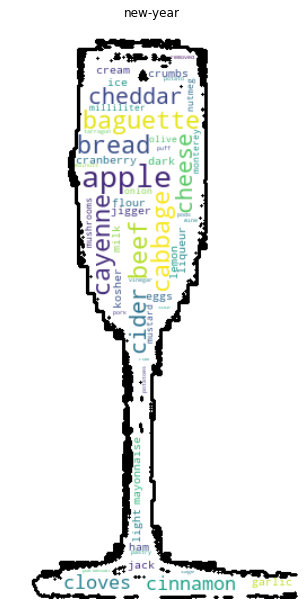

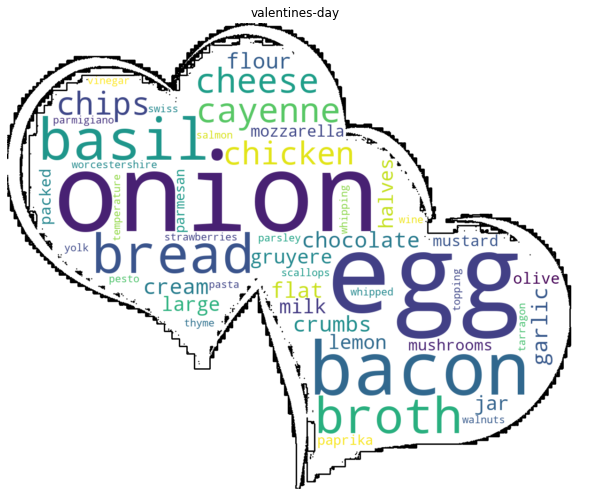

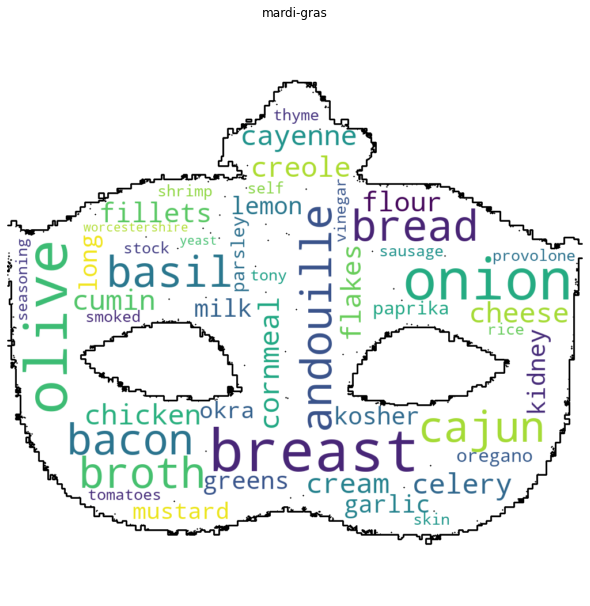

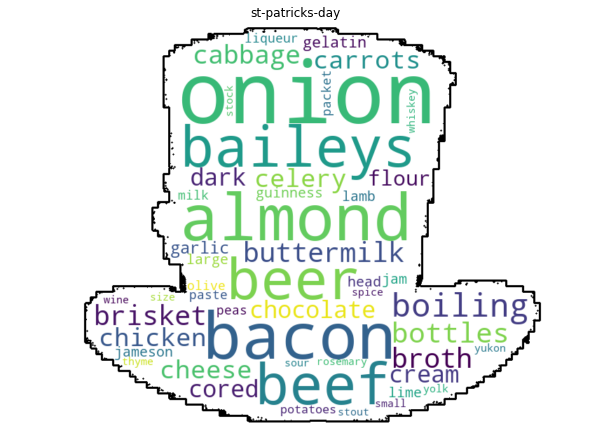

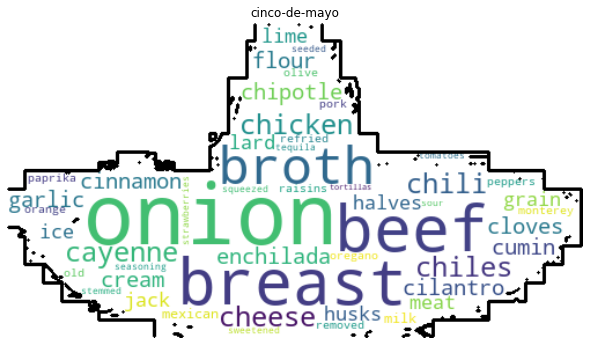

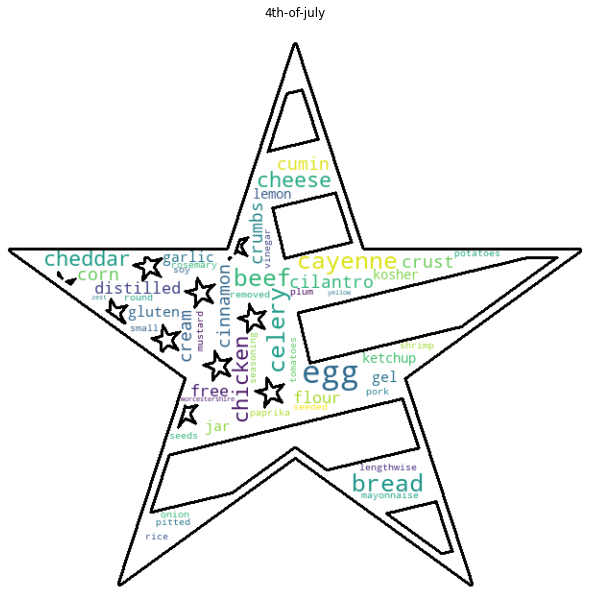

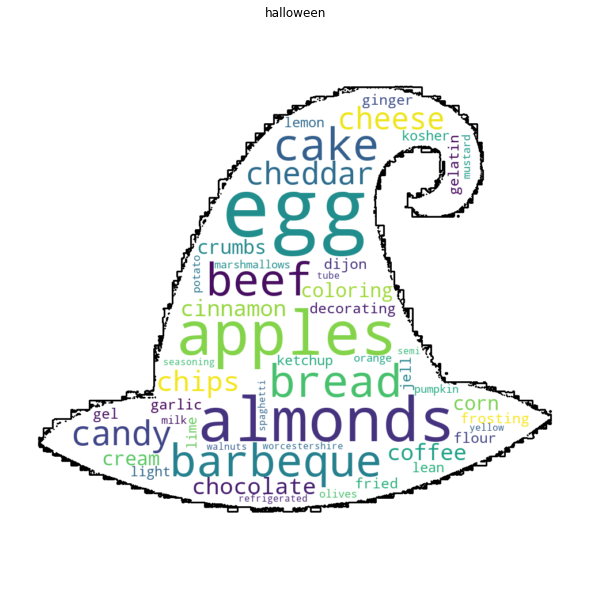

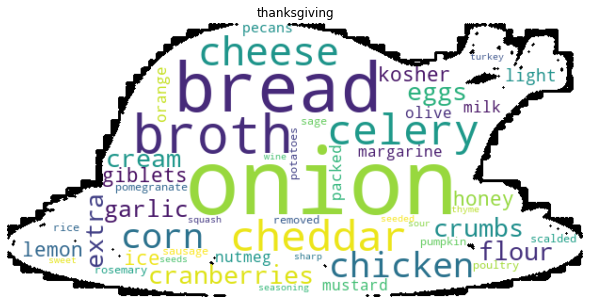

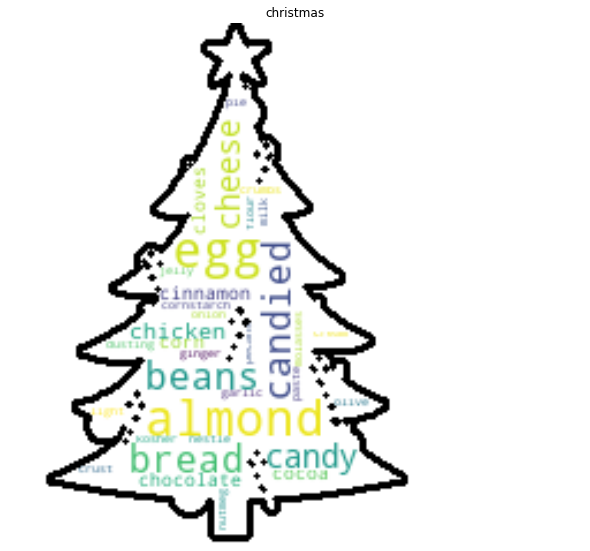

In [ ]:
#Radhika & Sarika
my_additional_stop_words = ['chopped','dried','ounce','shredded','fresh','ground','black','taste','minced','cut','sliced','white','water','package','salt','pepper','sugar','butter',
                            'oil','bell','powder','pieces','purpose','vanilla','softened','confectioners','peeled','diced','baking','inch','dry','needed', 'green', 'finely', 
                            'milimeter', 'drained', 'frozen', 'thinly', 'extract', 'half', 'hot', 'soda', 'divided', 'mix', 'thawed', 'grated', 'cubed', 'melted', 'red', 'brown',
                            'unbaked', 'cans', 'crushed', 'cubes', 'container', 'beaten', 'juiced', 'shoulder', 'brown', 'freshly', 'active', 'condensed', 'chunks', 'halved', 
                            'coarsely', 'leaves', 'irish', 'fluid', 'instant', 'corned', 'cold', 'pound', 'sauce', "boneless", 'unsalted', 'room', 'unsweetened', 'semisweet', 
                            'packages', 'italian', 'leaf', 'sea', 'frying', 'skinless', 'uncooked', 'deveined', 'gold', 'food', 'style', 'heavy', 'quartered', 'french', 
                            'slices', 'shortening', 'whites', 'miniature', 'flavored', 'juice', 'prepared', 'vegetable', 'neck', 'ounces', 'cooked', 'file', 'degrees']
#Radhika
corpus = frame['Ingredients']
val = 50
season_arr = []
dict_arr = []
fig = plt.figure(figsize=(18, 18))
for season in frame['Season'].unique():
    corpus = frame.loc[frame['Season'] == season, 'Ingredients']
    vectorizer = CountVectorizer(lowercase=True,stop_words = ENGLISH_STOP_WORDS.union(my_additional_stop_words), max_features = val)
    X = vectorizer.fit_transform(corpus)
    season_dict = array_counter(vectorizer.get_feature_names(),X.toarray(),val)
    #Sarika
    words = " ".join(key for key in season_dict.keys())
    mask = np.array(Image.open(season + ".png"))
    wordcloud = WordCloud(background_color='white', mask=mask, contour_width=3, contour_color='black', width=mask.shape[1],
               height=mask.shape[0], stopwords=ENGLISH_STOP_WORDS.union(my_additional_stop_words)).generate(words)                  
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(season)
    plt.show()

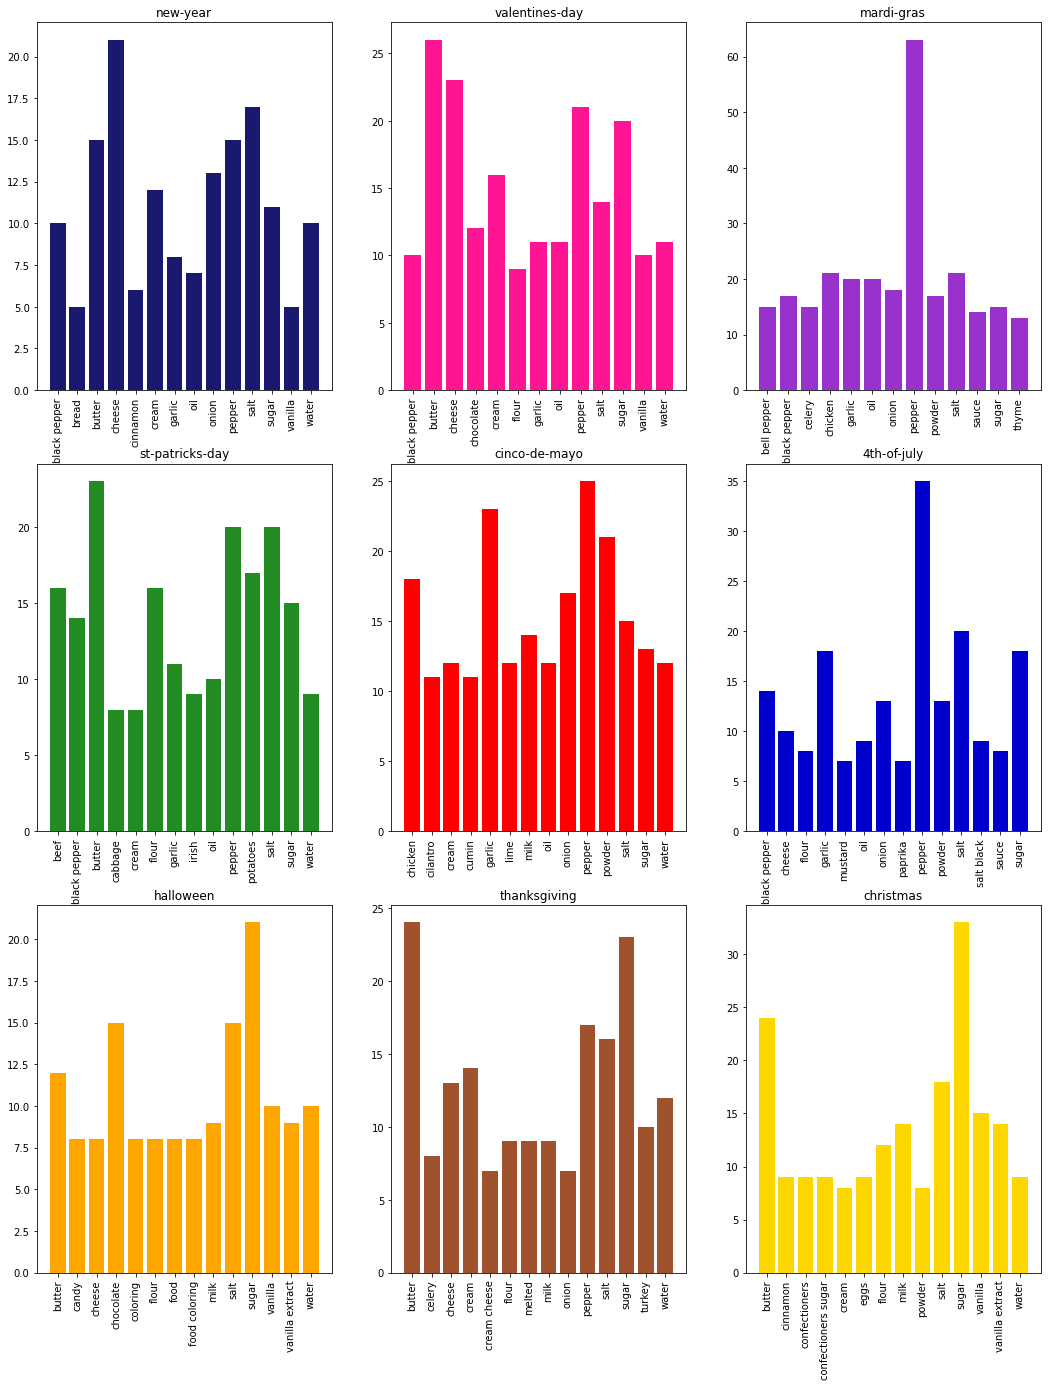

<Figure size 1440x1440 with 0 Axes>

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

my_additional_stop_words = ['chopped','dried','ounce','shredded','ground','taste','minced','cut','sliced','pieces','purpose','softened','peeled','diced','baking','inch','dry','needed', 'finely', 
                             'milimeter', 'drained', 'frozen', 'thinly', 'half', 'hot', 'soda', 'divided', 'mix','fresh', 'package', 'white', 'grated', 'juice', 'coarsely']
single_words =['green', 'black', 'extract', 'bell']
import matplotlib.pyplot as plt
import collections
corpus = frame['Ingredients']
val = 15
season_colors = {'new-year': 'midnightblue','valentines-day':'deeppink','mardi-gras':'darkorchid','st-patricks-day':'forestgreen','cinco-de-mayo':'red','4th-of-july':'mediumblue','halloween':'orange','thanksgiving':'sienna','christmas':'gold'}

season_arr = []
dict_arr = []
i = 1
fig = plt.figure(figsize=(18, 23))
for season in frame['Season'].unique():
    corpus = frame.loc[frame['Season'] == season, 'Ingredients']
    vectorizer = CountVectorizer(lowercase=True,stop_words = ENGLISH_STOP_WORDS.union(my_additional_stop_words),ngram_range=(1, 2), max_features=val)
    X = vectorizer.fit_transform(corpus)
    season_dict = array_counter(vectorizer.get_feature_names(),X.toarray(), val)
    for word in single_words:
      season_dict.pop(word, None)
    keys = season_dict.keys()
    values = season_dict.values()
    c = season_colors[season]
    ax = plt.subplot(3,3,i)
    ax.set_title(season)
    plt.bar(keys, values,color=c)
    plt.xticks(rotation=90)
    dict_arr.append(season_dict)
    season_arr.append(season)
    i+=1

plt.figure(figsize=(20,20))
plt.show()
final_dict = dict(zip(season_arr,dict_arr))

### Bar chart analysis
Here the bar charts we generated are not perfect. They contain words that shouldnt be there (such as 'melted' and 'food') But they do give us some insight into what to look for as well as some issues that will need addressing.

In each season, we can see some trends in certain ingredients which are popular among all seasons and also some which are only popular in a few seasons. Addtionally, there are some ingredients present in all seasons, but are disproportionaly present in certain seasons

For example, 'Vanilla' and 'Vanilla Extract' both appear to be occuring in roughly equal amounts. What this tells us is that Vanilla's count needs to be adjusted in each season.

given a dictioanry of dictionaries (as created like final_dict in the previous section), and a list of ingredients, **stackedBar** will make a stacked bar chart where each bar is an ingredient, and it is sectioned into the number of times the ingredient occurs within each holiday.

In [ ]:
#Jeremy
def stackedBar(counts, foods):
  season_colors = {'new-year': 'midnightblue','valentines-day':'deeppink','mardi-gras':'darkorchid','st-patricks-day':'forestgreen','cinco-de-mayo':'red','4th-of-july':'mediumblue','halloween':'orange','thanksgiving':'sienna','christmas':'gold'}
  seasons = ['new-year', 'valentines-day', 'mardi-gras', 'st-patricks-day', 'cinco-de-mayo', '4th-of-july', 'halloween', 'thanksgiving', 'christmas']
  foodPerSeason=[[counts[season].get(food) if counts[season].get(food) else 0 for food in foods] for season in seasons] #generates 2d array where each row is the counts of each food in a given season.
  previousLayer = [0 for food in foods]
  pos = list(range(len(foods)))
  plt.figure( figsize=(len(foods), len(seasons)))
  for n in range(len(seasons)):
    plt.bar(pos, foodPerSeason[n], bottom=previousLayer, edgecolor='white', width=.5)#add colors per season
    previousLayer =[x+y for x,y in zip(previousLayer, foodPerSeason[n])]
  plt.xticks(pos, foods)
  plt.yticks(range(0, 201, 25))
  plt.legend(seasons)
  plt.show()

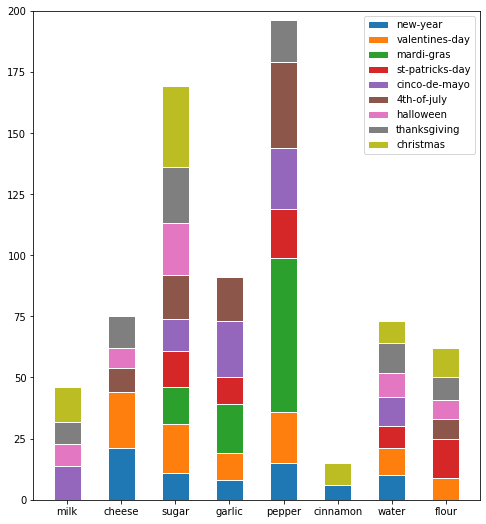

In [ ]:
stackedBar(final_dict, ['milk', 'cheese','sugar','garlic','pepper','cinnamon', 'water', 'flour'])


### Stacked bar chart analysis
The stacked bar chart allows us to see the distribution of an ingredient across all of the seasons. 

Cheese is mostly in new years and valentines day, cinnamon is mostly in christmas and new years.

This chart can be useful for identifying staple ingredients as well as any ingridients mostly unique to a season.


## Relational Analysis
Using the dataframe and dictionary, we created a new dataset and cleaned it further to help identify trends in ingredients and holidays

The new data frame we make is structured so that the rows are each of the ingredients and the columns are each season. this allows us to see the distribution of all ingredients across all seasons.
The issue with this new data frame, is that all of the ingredients present in the dataframe arent actual ingredients. We have to clean this by hand because certain issues must be handled on a case by case basis. Additionally, cleaning by hand allows us to easily see all garbage data that is there.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

my_additional_stop_words = ['chopped','dried','ounce','shredded','ground','taste','minced','cut','sliced','pieces','purpose','softened','peeled','diced','baking','inch','dry','needed', 'finely', 
                             'milimeter', 'drained', 'frozen', 'thinly', 'half', 'hot', 'soda', 'divided', 'mix','fresh', 'package', 'white', 'grated', 'coarsely']
single_words =['green', 'black', 'extract', 'bell']
import matplotlib.pyplot as plt
import collections
corpus = frame['Ingredients']
season_colors = {'new-year': 'midnightblue','valentines-day':'deeppink','mardi-gras':'darkorchid','st-patricks-day':'forestgreen','cinco-de-mayo':'red','4th-of-july':'mediumblue','halloween':'orange','thanksgiving':'sienna','christmas':'gold'}

season_arr = []
dict_arr = []
i = 1
for season in frame['Season'].unique():
    corpus = frame.loc[frame['Season'] == season, 'Ingredients']
    vectorizer = CountVectorizer(lowercase=True,stop_words = ENGLISH_STOP_WORDS.union(my_additional_stop_words),ngram_range=(1, 2))
    X = vectorizer.fit_transform(corpus)
    season_dict = array_counter(vectorizer.get_feature_names(),X.toarray(), len(X.toarray()[0]))
    for word in single_words:
      season_dict.pop(word, None)
    keys = season_dict.keys()
    values = season_dict.values()
    dict_arr.append(season_dict)
    season_arr.append(season)
    i+=1
final_dict2 = dict(zip(season_arr,dict_arr))
new_dict={}
for dic in final_dict2:
  new_dict[dic]={}
  for val in final_dict2[dic]:
    if final_dict2[dic][val] > 5:
      new_dict[dic][val]=final_dict2[dic][val]

### filtering out most useless info
Because the purpose of the analysis is to identify popular ingredients, we dont really care if something shows up only once or twice. Therefore, we only count ingredients for a season if it occurs more than 5 times in a season. 5 times is about 1/8 of our recipes for each season.

In [ ]:
def makeDF(dic):#takes a dictionary and makes a dataframe out of it.
  foods = []
  new_dic={}
  for season in dic:
    for food in dic[season]:
      if food not in foods:
        foods.append(food)
  for season in dic:
    new_dic[season]={}
    for food in foods:
      new_dic[season][food]= dic[season][food] if dic[season].get(food) else 0
  final_dict3 ={}
  for season in new_dic:
    final_dict3[season]=list(new_dic[season].values())
  return pd.DataFrame(final_dict3,index=foods)

In [ ]:
BadSet=makeDF(new_dict)
BadSet.head(20)

,new-year,valentines-day,mardi-gras,st-patricks-day,cinco-de-mayo,4th-of-july,halloween,thanksgiving,christmas
black pepper,10,10,17,14,11,14,0,7,0
butter,15,26,12,23,10,0,12,24,24
cheese,21,23,6,0,10,10,8,13,0
cinnamon,6,0,0,0,0,0,0,0,9
cream,12,16,0,8,12,7,6,14,8
garlic,8,11,20,11,23,18,0,7,0
juice,6,6,0,0,13,6,0,8,0
oil,7,11,20,10,12,9,6,6,0
onion,13,6,18,6,17,13,0,7,0
pepper,15,21,63,20,25,35,7,17,0


### Issues with this new dataframe
Here we can see a nice tabular display of data, but there are issues. One example of this is the fact that egg and eggs are coutned sepeartely when in reality they should be counted the same. 

This CSV/dataset was manually cleaned by the team due to the number of special cases present (do we merge egg and eggs? do we keep heavy and heavy cream? if not which do we get rid of?)

The cleaned CSV with shaded cells to show relations and unique ingredients can be found on github as 'CleanDataset.csv'

In [ ]:
BadSet.to_csv('DirtyDataset.csv')

# Data Analysis Summary

## Count vectorizer
This was used to determine how often each word occured in each holiday. Something that is critical to our analyis.


## Word Clouds
Words clouds were used to identify trends and differences between holidays because stacked bar charts could only really be used to identify staple ingredients and normal bar charts could really only be used when comparing small numbers of ingredients. Therefore, word clouds allowed for comparison of frequencies of many different ingredients between different holidays.


## Bar charts
Bar charts were used to show the trends in the most common ingredients in each season. These were prefferable to word clouds in this scenario because we were only graphing atmost 15 ingredients and they allowed for a more visual way to show the numeric frequencies in which they occured in each season.

## Stacked Bar Chart
Stacked Bar Charts were used to show the distribution of a given ingredient accross all of the holidays. This was key to allowing us to identify and confirm staple ingredients, relations, and unique ingredients.

## Ingidient/Holiday CSV
This CSV was used to more easily identify unique ingredients and staple ingredients.

#Conclusions
##(include graphics and discuss them) 
<!-- We think this project can benefit a lot of people. Since we are trying to find themes between recipes that are classified in different seasons, we will likely discover some staple ingredients people should always have on hand. People who like to entertain and host events or parties could greatly benefit. Because if those events are planned around a certain type of year such as a Holiday party or a Valentines Day party, the hosts would likely want to serve food that complements that time of year. Finding connections between recipes in different seasons could also promote creation and innovation. For example, if a specific ingredient is common in two different seasons, someone could find a way to modify one of their favorite recipes to fit into another season. -->

Our initial expectation of the project was that it would help is identifying staple ingredients that overlap across seasons that people should have on hand. Our main conclusion about staple ingredients 

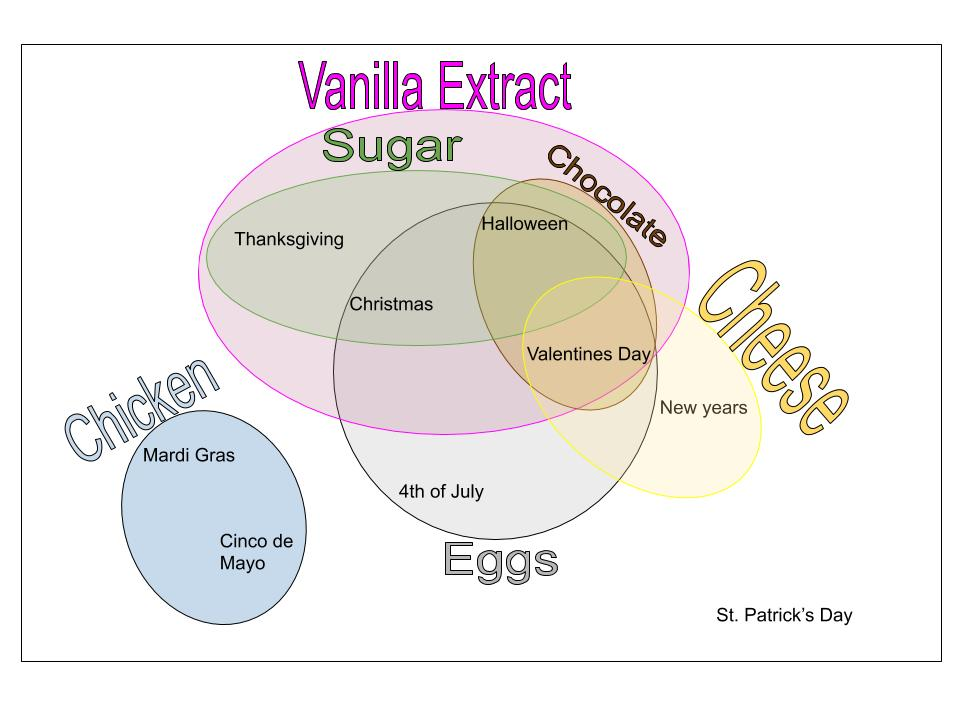

### Cluster Plot Graphic to show Relations
This graphic shows how certain holidays relate to eachother with certain ingredients.
Here, each circle has an ingredient associated with it, this indicates that this ingredient occurs much more frequently in the holidays inside the circle than those outside the circle.
For example, Chicken is much more common in Mardi Gras and Cinco de Mayo than any other holiday.

#Where to from here?

Due to this being a class with things such as the semester ending making it very hard to produce a more professional offering, there were many things we could not accomplish in the project. 

As mentioned before, we did not have a whole lot of data overall, especially compared to the other projects, due to only pulling data from one recipe website. Getting data from other sites is definitely something that we would have done, as well as analyzing the trends in the tags across the holidays. 
